In [29]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import json
import numpy as np

In [30]:
SCITSR_PATH = '/Users/longhoang/Developer/table-reg/data/scitsr-split-train'
CHUNK_JSON_LABEL = '/Users/longhoang/Developer/table-reg/data/SciTSR/train/label/chunk_label.json'

SCITSR_TRAIN = os.path.join(SCITSR_PATH, 'train')
SCITSR_VAL = os.path.join(SCITSR_PATH, 'val')

In [31]:
TRAIN_IMG_DIR = os.path.join(SCITSR_TRAIN, 'img')
imgs_paths = [os.path.join(TRAIN_IMG_DIR, p) for p in os.listdir(TRAIN_IMG_DIR)]
len(imgs_paths)

10000

In [32]:
with open(CHUNK_JSON_LABEL, 'r') as f:
    chunk_labels = json.load(f)

len(chunk_labels)

11971

In [33]:
def view_imgs(imgs, titles=None):
    fig = plt.figure(figsize=(7, 7))
    
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i + 1)
        
        if titles is not None:
            plt.title(titles[i])
        
        if img.ndim == 3:
            if img.shape[-1] == 3:
                plt.imshow(img)
            else:
                plt.imshow(img[..., 0], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    
    plt.show()

In [34]:
# load back ground truths for module Merge
MERGE_LABEL_PATH = os.path.join(SCITSR_TRAIN, 'label', 'merge_label.json')
with open(MERGE_LABEL_PATH, 'r') as f:
    merge_labels = json.load(f)
len(merge_labels)

10000

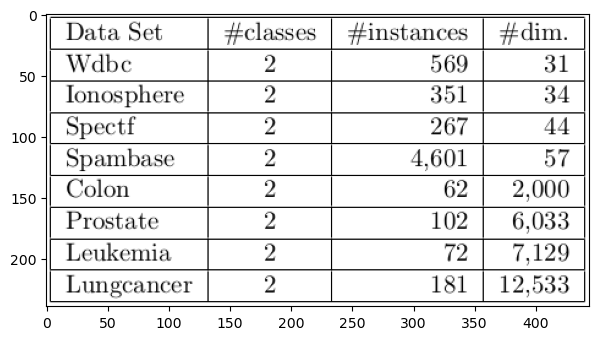

dtype('uint8')

In [35]:
idx = 60

def load_image(img_path):
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

img_path = imgs_paths[idx]
img = load_image(img_path).astype(np.uint8)
view_imgs([img])
img.dtype

In [36]:
def path2name(img_path):
    return os.path.splitext(os.path.basename(img_path))[0]

img_name = path2name(img_path)
img_name

'1608.05889v1.7'

In [37]:
gt = merge_labels[img_name]
rows, cols, R, D = gt['rows'], gt['columns'], gt['h_matrix'], gt['v_matrix']

rows, cols = np.array(rows), np.array(cols)
R, D = np.array(R), np.array(D)

In [38]:
h, w = len(rows), len(cols)
h, w

(239, 444)

In [39]:
img.shape

(239, 444, 3)

In [40]:
R.shape, D.shape

((9, 3), (8, 4))

In [41]:
rows_2d = np.tile(rows, (cols.shape[0], 1)).T
cols_2d = np.tile(cols, (rows.shape[0], 1))
rows_2d.shape, cols_2d.shape

((239, 444), (239, 444))

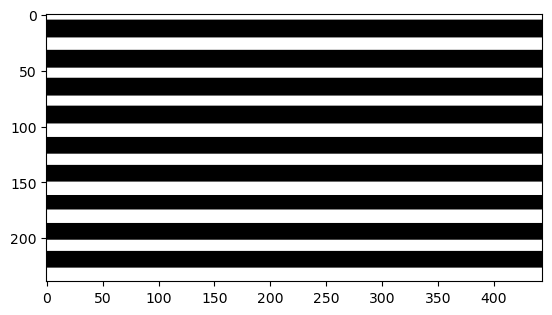

In [42]:
plt.imshow(rows_2d, cmap='gray')

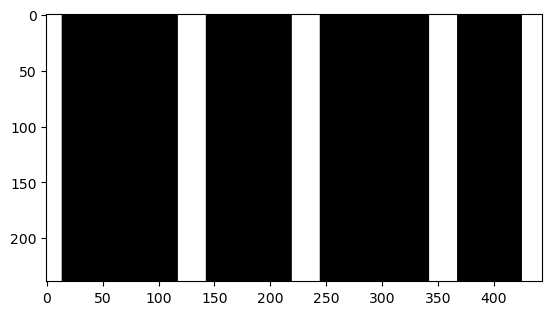

In [43]:
plt.imshow(cols_2d, cmap='gray')

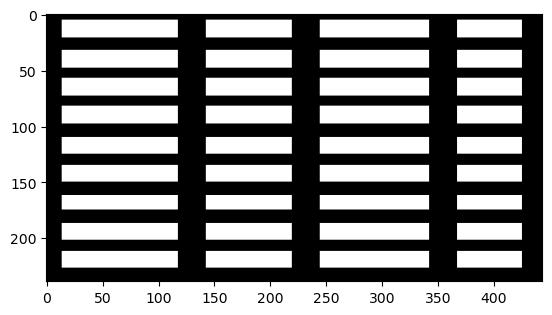

In [44]:
mask = (cv.bitwise_or(rows_2d, cols_2d) * 255).astype(np.uint8)
# plt.imshow(mask, cmap='gray')
mask_inv = cv.bitwise_not(mask)
plt.imshow(mask_inv, cmap='gray')

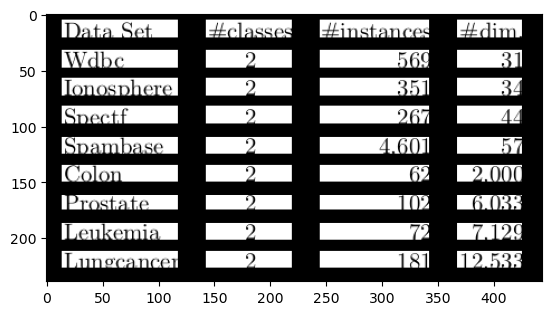

In [45]:
res = cv.bitwise_and(img, img, mask=mask_inv)
plt.imshow(res)

In [46]:
row_changes = np.array([abs(rows[i+1] - rows[i]) for i in range(len(rows) - 1)])
row_idxs = np.where(row_changes == 1)[0]

# check case where the first cell is right at the beginning of the row
if rows[0] == 0:  
    row_idxs = np.concatenate(([0], row_idxs))

# case where last cell right at the end of the row
if len(row_idxs) % 2 != 0:
    row_idxs = np.concatenate((row_idxs, [len(rows) - 1]))

row_idxs

array([  4,  20,  31,  47,  56,  72,  81,  97, 109, 124, 134, 149, 161,
       174, 186, 201, 211, 226])

In [47]:
col_changes = np.array([abs(cols[i+1] - cols[i]) for i in range(len(cols) - 1)])
col_idxs = np.where(col_changes == 1)[0]

if cols[0] == 0: 
    col_idxs = np.concatenate(([0], col_idxs))

if len(col_idxs) % 2 != 0:
    col_idxs = np.concatenate((col_idxs, [len(cols) - 1]))

col_idxs

array([ 13, 117, 142, 219, 244, 342, 367, 425])

In [48]:
cells = []
for i in range(0, len(row_idxs), 2):
    for j in range(0, len(col_idxs), 2):
        top, left = row_idxs[i], col_idxs[j]
        if (i + 1) >= len(row_idxs) or (j + 1) >= len(col_idxs): 
            continue
        bottom, right = row_idxs[i+1], col_idxs[j+1]
        print(f'({top}, {left}), ({bottom}, {right})')
        cells.append(((top, left), (bottom, right)))

(4, 13), (20, 117)
(4, 142), (20, 219)
(4, 244), (20, 342)
(4, 367), (20, 425)
(31, 13), (47, 117)
(31, 142), (47, 219)
(31, 244), (47, 342)
(31, 367), (47, 425)
(56, 13), (72, 117)
(56, 142), (72, 219)
(56, 244), (72, 342)
(56, 367), (72, 425)
(81, 13), (97, 117)
(81, 142), (97, 219)
(81, 244), (97, 342)
(81, 367), (97, 425)
(109, 13), (124, 117)
(109, 142), (124, 219)
(109, 244), (124, 342)
(109, 367), (124, 425)
(134, 13), (149, 117)
(134, 142), (149, 219)
(134, 244), (149, 342)
(134, 367), (149, 425)
(161, 13), (174, 117)
(161, 142), (174, 219)
(161, 244), (174, 342)
(161, 367), (174, 425)
(186, 13), (201, 117)
(186, 142), (201, 219)
(186, 244), (201, 342)
(186, 367), (201, 425)
(211, 13), (226, 117)
(211, 142), (226, 219)
(211, 244), (226, 342)
(211, 367), (226, 425)


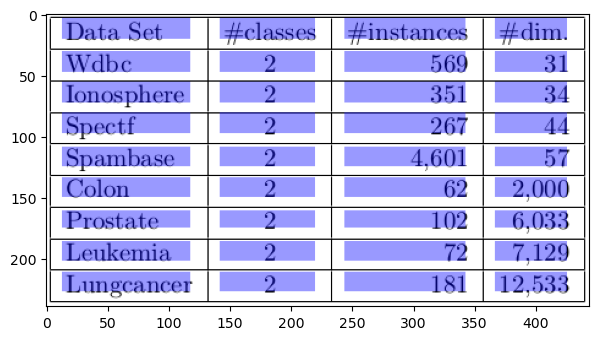

In [49]:
img_boxes = img.copy()

for (t, l), (b, r) in cells:
    cv.rectangle(img_boxes, (l, t), (r, b), (0, 0, 255), -1)
res = cv.addWeighted(img_boxes, 0.4, img, 0.6, 0)

view_imgs([res])

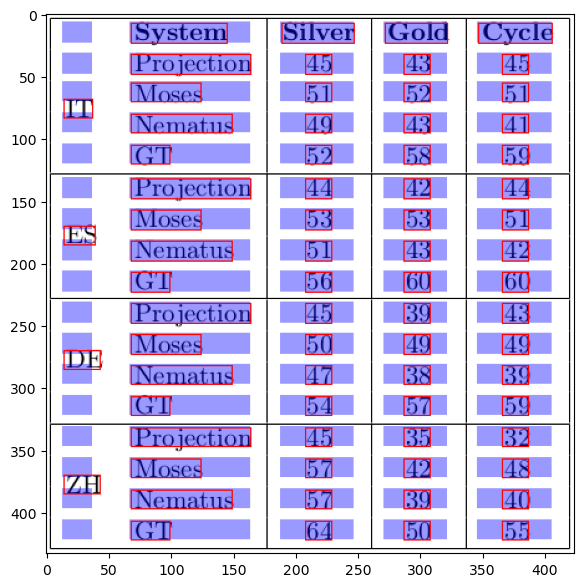

In [210]:
img2 = res.copy()

for text, (l, t, r, b) in chunk_labels[img_name]:
    cv.rectangle(img2, (l, t), (r, b), (255, 0, 0), 1)

view_imgs([img2])

`Rule 1:` Merge cells where predicted seperator passes through text

In [211]:
num_rows, num_cols = round(len(row_idxs) / 2), round(len(col_idxs) / 2)
num_rows, num_cols

(17, 5)

In [212]:
R_pred = np.zeros((num_rows, num_cols-1), dtype=np.uint8) # merge RIGHT matrix
D_pred = np.zeros((num_rows-1, num_cols), dtype=np.uint8) # merge DOWN matrix

R_pred.shape, D_pred.shape

((17, 4), (16, 5))

Find the Right and Down neighbor of a cell

In [213]:
idx = 0
cell = cells[idx]

cell

((6, 13), (22, 36))

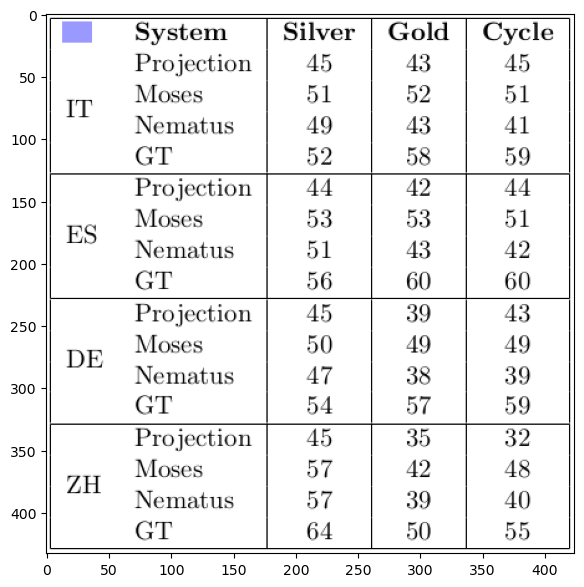

In [214]:
img3 = img.copy()

(t, l), (b, r) = cell
cv.rectangle(img3, (l, t), (r, b), (0, 0, 255), -1)
img_1cell = cv.addWeighted(img3, 0.4, img, 0.6, 0)

view_imgs([img_1cell])

In [215]:
def id2coord(id, n_cols):
    x = id // n_cols
    y = id % n_cols
    return x, y

In [216]:
def neighbor_RD(idx, num_rows, num_cols):
    idx_right = idx + 1 if (idx + 1) % num_cols != 0 else None
    idx_down = idx + num_cols if (idx + num_cols) < (num_rows * num_cols) else None
    return idx_right, idx_down

In [217]:
rn, dn = neighbor_RD(idx, num_rows, num_cols)
rn, dn

(1, 5)

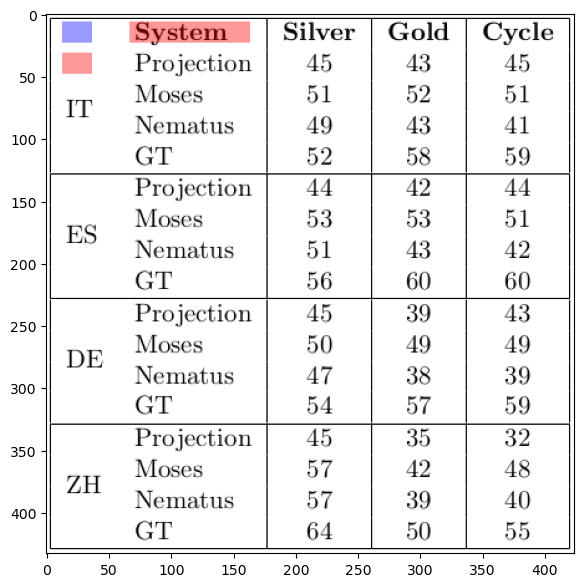

In [218]:
img4 = img.copy()
cv.rectangle(img4, (l, t), (r, b), (0, 0, 255), -1)

if rn:
    (t1, l1), (b1, r1) = cells[rn]
    cv.rectangle(img4, (l1, t1), (r1, b1), (255, 0, 0), -1)
if dn:
    (t2, l2), (b2, r2) = cells[dn]
    cv.rectangle(img4, (l2, t2), (r2, b2), (255, 0, 0), -1)

img_3cell = cv.addWeighted(img4, 0.4, img, 0.6, 0)
view_imgs([img_3cell])

In [219]:
# NOTE: these two functions are not quite efficient yet
def check_merge_right(id, id_r, cells, chunks):
    (top, left), (bottom, right) = cells[id]
    (_, left_r), (_, right_r) = cells[id_r]
    for text, (l, t, r, b) in chunks:
        if l < right and left_r < r and \
            (top < t < bottom or top < b < bottom):
            return True
    return False

def check_merge_down(id, id_d, cells, chunks):
    (top, left), (bottom, right) = cells[id]
    (top_d, _), (bottom_d, _) = cells[id_d]
    for text, (l, t, r, b) in chunks:
        if t < bottom and top_d < b and \
            (left < l < right or left < r < right):
            return True
    return False

In [220]:
chunks = chunk_labels[img_name]

In [221]:
for id, cell in enumerate(cells):
    merge_r, merge_d = None, None
    x, y = id2coord(id, num_cols)

    (t, l), (b, r) = cell
    rn, dn = neighbor_RD(id, num_rows, num_cols)
    if rn:
        merge_r = check_merge_right(id, rn, cells, chunks)
        if merge_r: 
            R_pred[x, y] = 1
            print(f'Merge right at cell ({x},{y})')
    if dn:
        merge_d = check_merge_down(id, dn, cells, chunks)
        if merge_d: 
            D_pred[x, y] = 1
            print(f'Merge down at cell ({x},{y})')
            
    # print(f'Cell ({x}, {y}) | Merge right: {merge_right} | Merge down: {merge_down}')

Merge down at cell (2,0)
Merge down at cell (6,0)
Merge down at cell (10,0)
Merge down at cell (14,0)


In [222]:
R_pred

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=uint8)

In [223]:
D_pred

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

`Rule 2:` In the first row (likely header row), merge non-blank cells with adjacent blank cells

In [224]:
def is_blank(id, cells, chunks):
    (top, left), (bottom, right) = cells[id]
    for text, (l, t, r, b) in chunks:
        if (top < b and bottom > t) and (left < r and right > l):
            return False
    return True

In [225]:
for id, cell in enumerate(cells):
    x, y = id2coord(id, num_cols)
    type_ = 'blank' if is_blank(id, cells, chunks) else 'non-blank'
    # print(f'Cell ({x},{y}): {type_}')

In [226]:
# NOTE: currently only merge right for cells in the first
#       row if its right neighbour is blank to avoid ambiguity

for id, cell in enumerate(cells):
    x, y = id2coord(id, num_cols)
    rn, dn = neighbor_RD(id, num_rows, num_cols)

    if x == 0 and rn: # first row and has right neighbour
        # if right cell is blank and current cell is non-blank, merge right
        if not is_blank(id, cells, chunks) and is_blank(rn, cells, chunks):
            R_pred[x, y] = 1
            print(f'Merge right at cell ({x},{y})')

In [227]:
R_pred

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=uint8)

In [228]:
D_pred

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [229]:
# # Merge blank cells together
# for id, cell in enumerate(cells):
#     x, y = id2coord(id, num_cols)
#     rn, dn = neighbor_RD(id, num_rows, num_cols)

#     if rn and is_blank(id, cells, chunks) and is_blank(rn, cells, chunks):
#         # if right cell is blank and current cell is blank, merge right
#         R_pred[x, y] = 1
#         print(f'Merge right at cell ({x},{y})')
#     if dn and is_blank(id, cells, chunks) and is_blank(dn, cells, chunks):
#         # if below cell is blank and current cell is blank, merge down
#         D_pred[x, y] = 1
#         print(f'Merge down at cell ({x},{y})')

# Evaluation

Use F-measure on Adjacency Relation Accuracy as the shape of groud truth and prediction might be different

In [230]:
print('R ground truth:', R.shape)
print('R prediction:', R_pred.shape)

R ground truth: (17, 4)
R prediction: (17, 4)


In [231]:
print('D ground truth:', D.shape)
print('D prediction:', D_pred.shape)

D ground truth: (16, 5)
D prediction: (16, 5)


In [278]:
# NOTE: might need to check L-shape case

def merge_right(cell, cell_right):
    (t1, l1), (b1, r1) = cell
    (t2, l2), (b2, r2) = cell_right
    assert t1 == t2 and b1 == b2, "Top and bottom of two cells don't match when merging right"
    assert l1 <= r2, "Cell to merge right is to the left of current cell"
    return ((t1, l1), (b1, r2))

def merge_down(cell, cell_down):
    (t1, l1), (b1, r1) = cell
    (t_down, l_down), (b_down, r_down) = cell_down
    assert l1 == l_down and r1 == r_down, "Left and right boundaries of two cells don't match when merging down"
    assert b1 <= t_down, "Cell to merge down is not just below the current cell"
    return ((t1, l1), (b_down, r1))

def merge_cells(cells, Rmatrix, Dmatrix, verbose=False):
    cells_mgr = []
    checked = []
    n_rows, n_cols = Rmatrix.shape[0], Dmatrix.shape[1]
    assert len(cells) == n_rows * n_cols, "Shape of R and D don't match the number of cells"
    for id, cell in enumerate(cells):
        if id in checked: continue
        x, y = id2coord(id, n_cols)
        rn_id, dn_id = neighbor_RD(id, n_rows, n_cols)
        if rn_id is not None and Rmatrix[x, y] == 1:
            if verbose: print(f'Merge right at cell ({x},{y})')
            cells_mgr.append(merge_right(cell, cells[rn_id]))
            checked.append(rn_id)
        elif dn_id is not None and Dmatrix[x, y] == 1:
            if verbose: print(f'Merge down at cell ({x},{y})')
            cells_mgr.append(merge_down(cell, cells[dn_id]))
            checked.append(dn_id)
        else:
            cells_mgr.append(cell)
    return cells_mgr

Merge down at cell (2,0)
Merge down at cell (6,0)
Merge down at cell (10,0)
Merge down at cell (14,0)


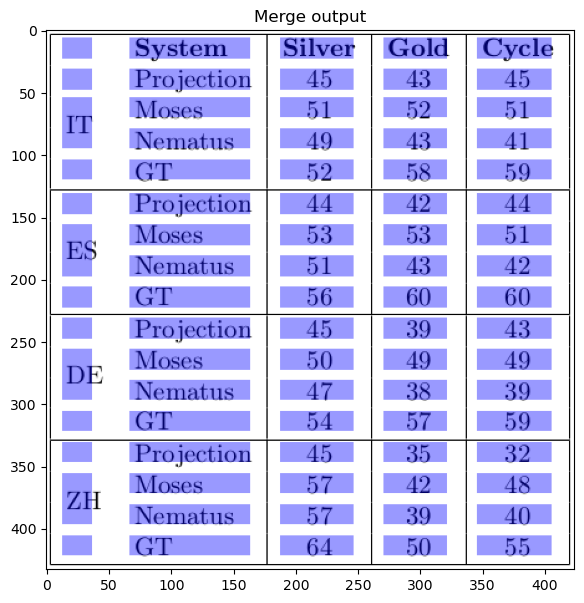

In [233]:
cells_merged = merge_cells(cells, R_pred, D_pred)
img_mgr = img.copy()

for (t, l), (b, r) in cells_merged:
    cv.rectangle(img_mgr, (l, t), (r, b), (0, 0, 255), -1)
res = cv.addWeighted(img_mgr, 0.4, img, 0.6, 0)

view_imgs([res], ['Merge output'])

Merge down at cell (1,0)
Merge down at cell (3,0)
Merge down at cell (5,0)
Merge down at cell (7,0)
Merge down at cell (9,0)
Merge down at cell (11,0)
Merge down at cell (13,0)
Merge down at cell (15,0)


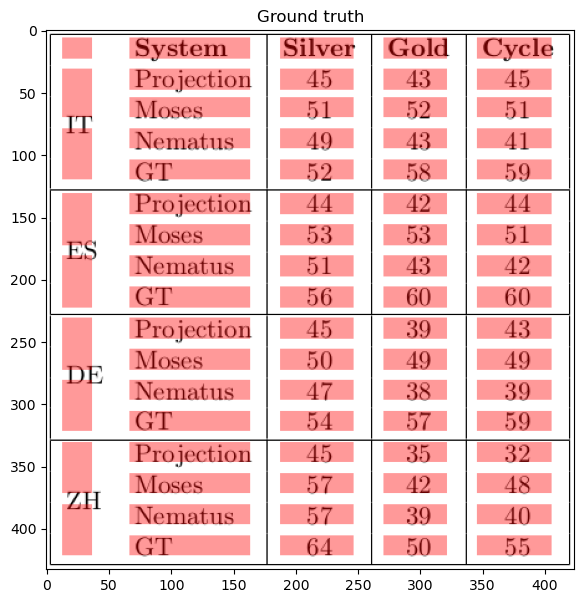

In [234]:
cells_gt = merge_cells(cells, R, D)

img_gt = img.copy()

for (t, l), (b, r) in cells_gt:
    cv.rectangle(img_gt, (l, t), (r, b), (255, 0, 0), -1)
res = cv.addWeighted(img_gt, 0.4, img, 0.6, 0)

view_imgs([res], ['Ground truth'])

In [235]:
def IoU(cell_1, cell_2):
    (t1, l1), (b1, r1) = cell_1
    (t2, l2), (b2, r2) = cell_2

    # Check for invalid bounding boxes
    if t1 >= b1 or l1 >= r1 or t2 >= b2 or l2 >= r2:
        print('Coordinates of the cells are invalid')
        return 0.0

    inner_top, inner_left = max(t1, t2), max(l1, l2)
    inner_bot, inner_right = min(b1, b2), min(r1, r2)

    if inner_bot >= inner_top and inner_right >= inner_left:
        inner_area = (inner_bot - inner_top) * (inner_right - inner_left)
        area_1 = (b1 - t1) * (r1 - l1)
        area_2 = (b2 - t2) * (r2 - l2)

        # Use floating-point division
        union_area = area_1 + area_2 - inner_area
        return inner_area / union_area if union_area > 0 else 0.0
    else:
        return 0.0

In [236]:
def eval(cells_pred, cells_label, threshold=0.7):
    '''Returns F1, recall, and precision score'''
    n_correct_preds = 0
    n_preds, n_true = len(cells_pred), len(cells_label)

    # Count true positives, false positives, and false negatives
    for pred_box in cells_pred:
        max_iou = 0
        for true_box in cells_label:
            iou = IoU(pred_box, true_box)
            if iou > max_iou:
                max_iou = iou

        if max_iou >= threshold:
            n_correct_preds += 1

    # Calculate precision, recall, and F1 score
    precision = n_correct_preds / n_preds if n_preds > 0 else 0.0
    recall = n_correct_preds / n_true if n_true > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1, recall, precision

In [237]:
eval(cells_merged, cells_gt)

(0.8734177215189873, 0.8961038961038961, 0.8518518518518519)

Putting everything together

In [271]:
def get_GT(merge_labels, img_name):
    gt = merge_labels[img_name]
    rows, cols, R, D = gt['rows'], gt['columns'], gt['h_matrix'], gt['v_matrix']
    rows, cols = np.array(rows), np.array(cols)
    R, D = np.array(R), np.array(D)
    return rows, cols, R, D

def get_row_col_idxs(rows, cols):
    row_changes = np.array([abs(rows[i+1] - rows[i]) for i in range(len(rows) - 1)])
    row_idxs = np.where(row_changes == 1)[0]

    # check case where the first cell is right at the beginning of the row
    if rows[0] == 0:  
        row_idxs = np.concatenate(([0], row_idxs))

    # case where last cell right at the end of the row
    if len(row_idxs) % 2 != 0:
        row_idxs = np.concatenate((row_idxs, [len(rows) - 1]))

    col_changes = np.array([abs(cols[i+1] - cols[i]) for i in range(len(cols) - 1)])
    col_idxs = np.where(col_changes == 1)[0]

    if cols[0] == 0: 
        col_idxs = np.concatenate(([0], col_idxs))

    if len(col_idxs) % 2 != 0:
        col_idxs = np.concatenate((col_idxs, [len(cols) - 1]))
    return row_idxs, col_idxs

def get_cells(row_idxs, col_idxs):
    cells = []
    for i in range(0, len(row_idxs), 2):
        for j in range(0, len(col_idxs), 2):
            top, left = row_idxs[i], col_idxs[j]
            if (i + 1) >= len(row_idxs) or (j + 1) >= len(col_idxs): 
                continue
            bottom, right = row_idxs[i+1], col_idxs[j+1]
            # print(f'({top}, {left}), ({bottom}, {right})')
            cells.append(((top, left), (bottom, right)))
    return cells

def create_pred_matrices(num_rows, num_cols):
    R_pred = np.zeros((num_rows, num_cols-1), dtype=np.uint8) # merge RIGHT matrix
    D_pred = np.zeros((num_rows-1, num_cols), dtype=np.uint8) # merge DOWN matrix
    return R_pred, D_pred

def merge_seperator(cells, chunks, R_pred, D_pred, verbose=False):
    num_rows, num_cols = R_pred.shape[0], D_pred.shape[1]
    for id, cell in enumerate(cells):
        merge_r, merge_d = None, None
        x, y = id2coord(id, num_cols)

        (t, l), (b, r) = cell
        rn, dn = neighbor_RD(id, num_rows, num_cols)
        if rn:
            merge_r = check_merge_right(id, rn, cells, chunks)
            if merge_r: 
                R_pred[x, y] = 1
                if verbose: print(f'Merge right at cell ({x},{y})')
        if dn:
            merge_d = check_merge_down(id, dn, cells, chunks)
            if merge_d: 
                D_pred[x, y] = 1
                if verbose: print(f'Merge down at cell ({x},{y})')
    return R_pred, D_pred

def merge_blank_1st_row(cells, chunks, R_pred, D_pred, verbose=False):
    num_rows, num_cols = R_pred.shape[0], D_pred.shape[1]
    for id, cell in enumerate(cells):
        x, y = id2coord(id, num_cols)
        rn, dn = neighbor_RD(id, num_rows, num_cols)

        if x == 0 and rn: # first row and has right neighbour
            # if right cell is blank and current cell is non-blank, merge right
            if not is_blank(id, cells, chunks) and is_blank(rn, cells, chunks):
                R_pred[x, y] = 1
                if verbose: print(f'Merge right at cell ({x},{y})')
    return R_pred, D_pred

In [281]:
def merge_heuristics(img_dir: str, merge_json: str, chunk_json: str):
    '''
    Args:
    img_dir -- string, path to image folder of train or test set
    merge_json -- string, path to json ground truth file for merge module
    chunk_json -- string, patht to json file that contain chunk info (coordinates of texts)
    '''
    # Load images
    imgs_paths = [os.path.join(img_dir, p) for p in os.listdir(img_dir)]
    print(f'Got {len(imgs_paths)} images')

    # Load Merge labels
    with open(merge_json, 'r') as f:
        merge_labels = json.load(f)
    print(f"Loaded {len(merge_labels)} labels for Merge module")

    # Load Chunk info
    with open(chunk_json, 'r') as f:
        chunk_labels = json.load(f)
    print(f"Loaded {len(chunk_labels)} Chunk info")

    n_sizes_differ = 0
    f1s, recalls, precisions = [], [], []
    for i, img_path in enumerate(imgs_paths):
        img_name = path2name(img_path)
        # img = load_image(img_path).astype(np.uint8)
        # view_imgs([img])

        # Ground truth for the image
        rows, cols, R, D = get_GT(merge_labels, img_name)
        row_idxs, col_idxs = get_row_col_idxs(rows, cols)
        # Get single cells 
        cells = get_cells(row_idxs, col_idxs)
        # Create merge prediction matrices
        num_rows, num_cols = round(len(row_idxs) / 2), round(len(col_idxs) / 2)
        if num_rows <= 0 or num_cols <= 0:
            print(img_path)
            continue
        R_pred, D_pred = create_pred_matrices(num_rows, num_cols)
        # Rule 1: seperator passing through texts
        chunks = chunk_labels[img_name]
        R_pred, D_pred = merge_seperator(cells, chunks, R_pred, D_pred)
        # Rule 2: merge non-blank cells in first row with other adjacent blank cells 
        # NOTE: unfinished
        R_pred, D_pred = merge_blank_1st_row(cells, chunks, R_pred, D_pred)
        # NOTE: other rules to be updated in the future
        if (R.shape != R_pred.shape or D.shape != D_pred.shape):
            n_sizes_differ += 1
            continue # NOTE: fix size difference case

        cells_merged = merge_cells(cells, R_pred, D_pred)
        cells_gt = merge_cells(cells, R, D)
        f1, rec, prec = eval(cells_merged, cells_gt)
        f1s.append(f1); recalls.append(rec); precisions.append(prec)

    f1_avg, rec_avg, prec_avg = np.mean(f1s), np.mean(recalls), np.mean(precisions)
    print('Number of matrice size difference (between GT and prediction):', n_sizes_differ)
    print(f'F1: {f1_avg:.4f} ; Recall: {rec_avg:.4f} ; Precision: {prec_avg:.4f}')

merge_heuristics(TRAIN_IMG_DIR, MERGE_LABEL_PATH, CHUNK_JSON_LABEL)

Got 10000 images
Loaded 10000 labels for Merge module
Loaded 11971 Chunk info
/Users/longhoang/Developer/table-reg/data/scitsr-split-train/train/img/1605.06650v2.4.png
Number of matrice size difference (between GT and prediction): 1071
F1: 0.9866 ; Recall: 0.9888 ; Precision: 0.9847
